In [7]:
!pip install pytorch-lamb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 29.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 KB 30.2 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel,AdamW
import numpy as np
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from glob import glob
import os
import time
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
# Assuming you have 'flash_attn_interface' properly installed and imported
from flash_attn_interface import flash_attention
torch.manual_seed(0)
class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        head_dim = config.hidden_size // self.num_attention_heads

        # Define linear layers for q, k, v transformations
        self.query = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)
        self.key = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)
        self.value = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)

    def forward(self, hidden_states, attention_mask=None, head_mask=None):
        if hidden_states.dim() == 2:
            # Add a sequence length dimension if it's missing
            hidden_states = hidden_states.unsqueeze(1)
        # print(f"Hidden States shape is {hidden_states.shape}")
        batch_size, seq_length, hidden_size = hidden_states.size()
        assert hidden_size % self.num_attention_heads == 0, "Hidden size must be divisible by the number of attention heads"

        # Apply linear transformations to get q, k, v
        q = self.query(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)
        k = self.key(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)
        v = self.value(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)

        q, k, v = [x.permute(0, 2, 1, 3).to(torch.float16) for x in (q, k, v)]
        # Call flash_attention
        print(q.shape)
        flash_output = flash_attention(q, k, v, dropout_prob=0.0, causal=False)
        flash_output = flash_output.to(torch.float32)
        # Reshape and return the new hidden state
        flash_output = flash_output.permute(0, 2, 1, 3).contiguous()
        new_hidden_state = flash_output.view(batch_size, seq_length, hidden_size)

        return new_hidden_state.to(torch.float32)

class CustomBertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertSelfAttention(config)
        self.attention_output_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_activation = nn.GELU()
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.output_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, 
                encoder_hidden_states=None, encoder_attention_mask=None, 
                past_key_values=None, output_attentions=False):
        # Attention block
        # print("Hidden states shape in CustomBertLayer:", hidden_states.shape)
        # print("Attention Starts")
        attention_output = self.attention(hidden_states, attention_mask)
        # print("Attention Ends")
        attention_output = self.attention_output_norm(attention_output + hidden_states)  # Add residual connection
    
        # Intermediate and output block (Feed-forward)
        intermediate_output = self.intermediate(attention_output)
        intermediate_output = self.intermediate_activation(intermediate_output)
        layer_output = self.output(intermediate_output)
        layer_output = self.output_norm(layer_output + attention_output)  # Add residual connection
        layer_output = layer_output.repeat(11, 1, 1, 1)
        return layer_output



class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        # Replace default BertLayer with CustomBertLayer in the encoder
        self.encoder.layer = nn.ModuleList([CustomBertLayer(config) for _ in range(config.num_hidden_layers)])
        # Add a linear layer to project hidden states to vocabulary size
        self.cls = nn.Linear(config.hidden_size, config.vocab_size)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_ids.size(), input_ids.device)
        head_mask = self.get_head_mask(None, self.config.num_hidden_layers)

        # Get embeddings from the BERT embeddings layer
        embedding_output = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        # Forward pass through the encoder layers
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True
        )
        
        # The last hidden state from the encoder output
        sequence_output = encoder_outputs.last_hidden_state
        # Project hidden states to vocabulary size
        logits = self.cls(sequence_output)

        return logits

# Function to get current memory usage
def get_gpu_memory_usage():
    # Returns the current GPU memory usage in MB
    allocated = torch.cuda.memory_allocated() / (1024 * 1024)
    cached = torch.cuda.memory_reserved() / (1024 * 1024)
    return allocated, cached

class TextFolderDataset(Dataset):
    def __init__(self, file_directory, file_pattern, tokenizer, max_length):
        self.filepaths = glob(os.path.join(file_directory, file_pattern))
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        with open(self.filepaths[idx], 'r', encoding='utf-8') as file:
            text = file.read()
        encoding = self.tokenizer.encode(text)
        input_ids = encoding.ids[:self.max_length] + [0] * (self.max_length - len(encoding.ids[:self.max_length]))
        attention_mask = [1] * len(encoding.ids[:self.max_length]) + [0] * (self.max_length - len(encoding.ids[:self.max_length]))
        
        # Create labels (for masked language modeling, you might mask some tokens here)
        labels = input_ids[:]  # In practice, apply masking strategy here

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)  # Add labels
        }

# Function to train a WordPiece tokenizer
def train_tokenizer(file_directory, file_pattern):
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordPieceTrainer(
        vocab_size=30522,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )
    files = glob(os.path.join(file_directory, file_pattern))
    tokenizer.train(files, trainer)
    return tokenizer

def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels.
    It flattens both the predictions and labels arrays to compare them element-wise.
    """
    # Convert the highest logit to predicted label (argmax over the last dimension)
    pred_flat = np.argmax(preds, axis=2).flatten()
    
    # Flatten the true labels array
    labels_flat = labels.flatten()

    # Calculate the number of correct predictions
    correct_predictions = np.sum(pred_flat == labels_flat)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / len(labels_flat)
    
    return accuracy



# Your training and evaluation code
max_lengths = [128, 256, 512, 768, 1024,1200,1300,1400,1900,2300,2800]
training_times = []
memory_usages = []

file_directory = "openwebtext/"
file_pattern = "urlsf_subset01-32*"
eval_file_pattern = 'urlsf_subset01-33*'
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30
for max_length in max_lengths:
    # Your existing tokenizer training, dataset creation, etc.
    print("Processing max_length:", max_length)
    tokenizer = train_tokenizer(file_directory, file_pattern)
    tokenizer.save(f"model/tokenizer_bert_flash_attn_{max_length}.json")
    tokenizer = Tokenizer.from_file(f"model/tokenizer_bert_flash_attn_{max_length}.json")
    dataset = TextFolderDataset(file_directory, file_pattern, tokenizer, max_length)
    eval_dataset = TextFolderDataset(file_directory, eval_file_pattern, tokenizer, max_length)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
    eval_data_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)
    config = BertConfig(
        vocab_size=tokenizer.get_vocab_size(),
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        max_position_embeddings=max_length,
    )

    custom_model = CustomBertModel(config).to(torch.device("cuda"))
    # custom_model = custom_model.half()  # Convert model's parameters and buffers to half precision

    optimizer = AdamW(custom_model.parameters(), lr=5e-5)
    start_time = time.time()
    start_allocated, start_cached = get_gpu_memory_usage()

    # Training loop (simplified)
    custom_model.train()
    scaler = GradScaler()
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            input_ids = batch['input_ids'].to(torch.device("cuda"), dtype=torch.long)
            attention_mask = batch['attention_mask'].to(torch.device("cuda"), dtype=torch.long)
            labels = batch['labels'].to(torch.device("cuda"), dtype=torch.long)  # Shape: [batch_size, seq_length]
    
            optimizer.zero_grad()
            with autocast():
                logits = custom_model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, seq_length, num_classes]
    
                # Flatten logits to shape [batch_size * seq_length, num_classes]
                logits_flat = logits.view(-1, logits.size(-1))
        
                # Flatten labels to shape [batch_size * seq_length], keep as torch.long
                labels_flat = labels.view(-1)
        
                loss = loss_fn(logits_flat, labels_flat)
            # print(" The type for the loss is ")
            # print(loss.dtype)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss += loss.item()

        avg_loss = total_loss / input_ids.shape[0]
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        if avg_loss < 0.5:
            break
 
    end_time = time.time()
    end_allocated, end_cached = get_gpu_memory_usage()
    delta_cached = end_cached - start_cached
    training_times.append(end_time - start_time)
    memory_usages.append(delta_cached)
    del custom_model, optimizer, tokenizer, dataset, eval_dataset, data_loader, eval_data_loader
    torch.cuda.empty_cache()

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(max_lengths, training_times, marker='o')
plt.title('Training Time vs Max Length')
plt.xlabel('Max Length')
plt.ylabel('Training Time (seconds)')
plt.subplot(1, 2, 2)
plt.plot(max_lengths, memory_usages, marker='o')
plt.title('Memory Usage vs Max Length')
plt.xlabel('Max Length')
plt.ylabel('Memory Usage (MB)')
plt.tight_layout()
plt.show()

Processing max_length: 128



torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
Epoch 1/30, Average Loss: 0.9488
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
torch.Size([11, 12, 128, 64])
Epoch 2/30, Average Loss: 0.8757


KeyboardInterrupt: 

In [2]:
print(training_times)

[57.50393986701965, 77.59242367744446, 91.95445609092712, 96.26931309700012, 104.74510741233826]


In [3]:
print(memory_usages)

[2330.0, 1908.0, 3972.0, 5146.0, 6852.0]


Processing max_length: 1900





/home/m/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/m/.local/lib/python3.10/site-packages/transformers/modeling_utils.py:942: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Epoch 1/30, Average Loss: 0.9566
Epoch 2/30, Average Loss: 0.8937
Epoch 3/30, Average Loss: 0.8429
Epoch 4/30, Average Loss: 0.8030
Epoch 5/30, Average Loss: 0.7703
Epoch 6/30, Average Loss: 0.7439
Epoch 7/30, Average Loss: 0.7220
Epoch 8/30, Average Loss: 0.7025
Epoch 9/30, Average Loss: 0.6843
Epoch 10/30, Average Loss: 0.6675
Epoch 11/30, Average Loss: 0.6522
Epoch 12/30, Average Loss: 0.6375
Epoch 13/30, Average Loss: 0.6236
Epoch 14/30, Average Loss: 0.6106
Epoch 15/30, Average Loss: 0.5983
Epoch 16/30, Average Loss: 0.5865
Epoch 17/30, Average Loss: 0.5750
Epoch 18/30, Average Loss: 0.5635
Epoch 19/30, Average Loss: 0.5528
Epoch 20/30, Average Loss: 0.5422
Epoch 21/30, Average Loss: 0.5321
Epoch 22/30, Average Loss: 0.5221
Epoch 23/30, Average Loss: 0.5121
Epoch 24/30, Average Loss: 0.5025
Epoch 25/30, Average Loss: 0.4934
Processing max_length: 2300





/home/m/.local/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/30, Average Loss: 0.9561
Epoch 2/30, Average Loss: 0.8945
Epoch 3/30, Average Loss: 0.8454
Epoch 4/30, Average Loss: 0.8054
Epoch 5/30, Average Loss: 0.7712
Epoch 6/30, Average Loss: 0.7429
Epoch 7/30, Average Loss: 0.7193
Epoch 8/30, Average Loss: 0.6984
Epoch 9/30, Average Loss: 0.6796
Epoch 10/30, Average Loss: 0.6625
Epoch 11/30, Average Loss: 0.6464
Epoch 12/30, Average Loss: 0.6316
Epoch 13/30, Average Loss: 0.6182
Epoch 14/30, Average Loss: 0.6050
Epoch 15/30, Average Loss: 0.5929
Epoch 16/30, Average Loss: 0.5810
Epoch 17/30, Average Loss: 0.5698
Epoch 18/30, Average Loss: 0.5589
Epoch 19/30, Average Loss: 0.5482
Epoch 20/30, Average Loss: 0.5383
Epoch 21/30, Average Loss: 0.5282
Epoch 22/30, Average Loss: 0.5185
Epoch 23/30, Average Loss: 0.5090
Epoch 24/30, Average Loss: 0.5002
Epoch 25/30, Average Loss: 0.4912
Processing max_length: 2800



Epoch 1/30, Average Loss: 0.9529
Epoch 2/30, Average Loss: 0.8934
Epoch 3/30, Average Loss: 0.8455
Epoch 4/30, Average Loss: 0.8

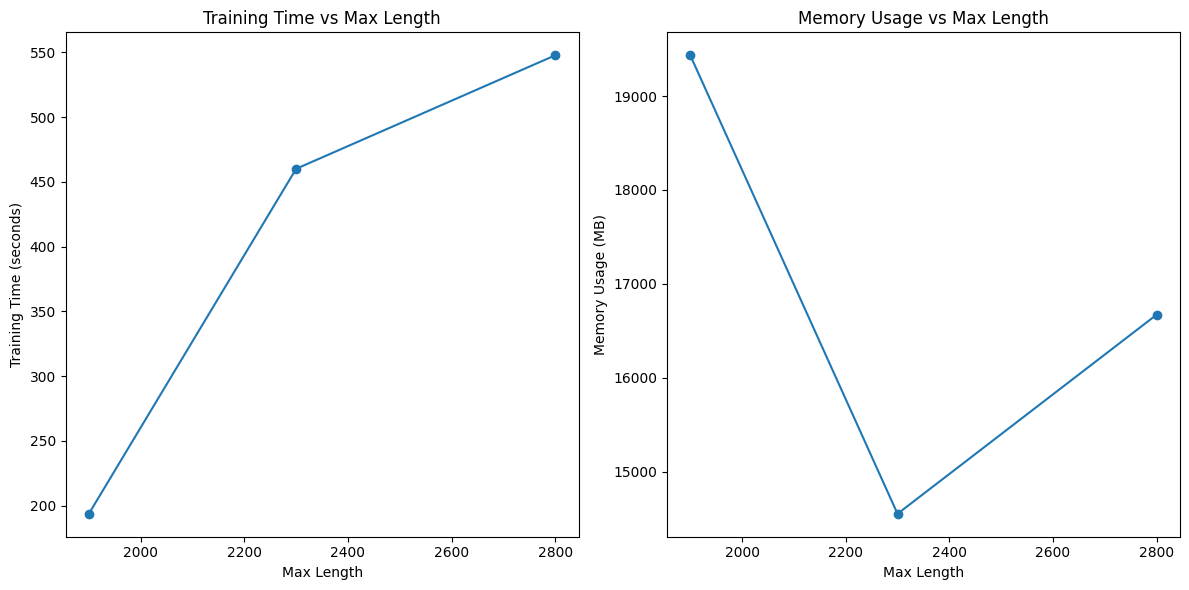

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertConfig, BertModel,AdamW
import numpy as np
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from glob import glob
import os
import time
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
# Assuming you have 'flash_attn_interface' properly installed and imported
from flash_attn_interface import flash_attention

class BertSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        head_dim = config.hidden_size // self.num_attention_heads

        # Define linear layers for q, k, v transformations
        self.query = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)
        self.key = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)
        self.value = nn.Linear(config.hidden_size, self.num_attention_heads * head_dim)

    def forward(self, hidden_states, attention_mask=None, head_mask=None):
        if hidden_states.dim() == 2:
            # Add a sequence length dimension if it's missing
            hidden_states = hidden_states.unsqueeze(1)
        # print(f"Hidden States shape is {hidden_states.shape}")
        batch_size, seq_length, hidden_size = hidden_states.size()
        assert hidden_size % self.num_attention_heads == 0, "Hidden size must be divisible by the number of attention heads"

        # Apply linear transformations to get q, k, v
        q = self.query(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)
        k = self.key(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)
        v = self.value(hidden_states).view(batch_size, seq_length, self.num_attention_heads, -1)

        q, k, v = [x.permute(0, 2, 1, 3).to(torch.float16) for x in (q, k, v)]
        # Call flash_attention
        flash_output = flash_attention(q, k, v, dropout_prob=0.0, causal=False)
        flash_output = flash_output.to(torch.float32)
        # Reshape and return the new hidden state
        flash_output = flash_output.permute(0, 2, 1, 3).contiguous()
        new_hidden_state = flash_output.view(batch_size, seq_length, hidden_size)

        return new_hidden_state.to(torch.float32)

class CustomBertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BertSelfAttention(config)
        self.attention_output_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_activation = nn.GELU()
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.output_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, 
                encoder_hidden_states=None, encoder_attention_mask=None, 
                past_key_values=None, output_attentions=False):
        # Attention block
        # print("Hidden states shape in CustomBertLayer:", hidden_states.shape)
        # print("Attention Starts")
        attention_output = self.attention(hidden_states, attention_mask)
        # print("Attention Ends")
        attention_output = self.attention_output_norm(attention_output + hidden_states)  # Add residual connection
    
        # Intermediate and output block (Feed-forward)
        intermediate_output = self.intermediate(attention_output)
        intermediate_output = self.intermediate_activation(intermediate_output)
        layer_output = self.output(intermediate_output)
        layer_output = self.output_norm(layer_output + attention_output)  # Add residual connection
        layer_output = layer_output.repeat(11, 1, 1, 1)
        return layer_output



class CustomBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        # Replace default BertLayer with CustomBertLayer in the encoder
        self.encoder.layer = nn.ModuleList([CustomBertLayer(config) for _ in range(config.num_hidden_layers)])
        # Add a linear layer to project hidden states to vocabulary size
        self.cls = nn.Linear(config.hidden_size, config.vocab_size)
        
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        extended_attention_mask = self.get_extended_attention_mask(attention_mask, input_ids.size(), input_ids.device)
        head_mask = self.get_head_mask(None, self.config.num_hidden_layers)

        # Get embeddings from the BERT embeddings layer
        embedding_output = self.embeddings(input_ids=input_ids, token_type_ids=token_type_ids)

        # Forward pass through the encoder layers
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=None,
            encoder_attention_mask=None,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=True
        )
        
        # The last hidden state from the encoder output
        sequence_output = encoder_outputs.last_hidden_state
        # Project hidden states to vocabulary size
        logits = self.cls(sequence_output)

        return logits

# Function to get current memory usage
def get_gpu_memory_usage():
    # Returns the current GPU memory usage in MB
    allocated = torch.cuda.memory_allocated() / (1024 * 1024)
    cached = torch.cuda.memory_reserved() / (1024 * 1024)
    return allocated, cached

class TextFolderDataset(Dataset):
    def __init__(self, file_directory, file_pattern, tokenizer, max_length):
        self.filepaths = glob(os.path.join(file_directory, file_pattern))
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        with open(self.filepaths[idx], 'r', encoding='utf-8') as file:
            text = file.read()
        encoding = self.tokenizer.encode(text)
        input_ids = encoding.ids[:self.max_length] + [0] * (self.max_length - len(encoding.ids[:self.max_length]))
        attention_mask = [1] * len(encoding.ids[:self.max_length]) + [0] * (self.max_length - len(encoding.ids[:self.max_length]))
        
        # Create labels (for masked language modeling, you might mask some tokens here)
        labels = input_ids[:]  # In practice, apply masking strategy here

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)  # Add labels
        }

# Function to train a WordPiece tokenizer
def train_tokenizer(file_directory, file_pattern):
    tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
    tokenizer.pre_tokenizer = Whitespace()
    trainer = WordPieceTrainer(
        vocab_size=30522,
        special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
    )
    files = glob(os.path.join(file_directory, file_pattern))
    tokenizer.train(files, trainer)
    return tokenizer

def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels.
    It flattens both the predictions and labels arrays to compare them element-wise.
    """
    # Convert the highest logit to predicted label (argmax over the last dimension)
    pred_flat = np.argmax(preds, axis=2).flatten()
    
    # Flatten the true labels array
    labels_flat = labels.flatten()

    # Calculate the number of correct predictions
    correct_predictions = np.sum(pred_flat == labels_flat)

    # Calculate accuracy as the ratio of correct predictions to total predictions
    accuracy = correct_predictions / len(labels_flat)
    
    return accuracy


# Your training and evaluation code
max_lengths = [1900,2300,2800]
training_times = []
memory_usages = []

file_directory = "openwebtext/"
file_pattern = "urlsf_subset01-32*"
eval_file_pattern = 'urlsf_subset01-33*'
loss_fn = nn.CrossEntropyLoss()
num_epochs = 30
for max_length in max_lengths:
    # Your existing tokenizer training, dataset creation, etc.
    print("Processing max_length:", max_length)
    tokenizer = train_tokenizer(file_directory, file_pattern)
    tokenizer.save(f"model/tokenizer_bert_flash_attn_{max_length}.json")
    tokenizer = Tokenizer.from_file(f"model/tokenizer_bert_flash_attn_{max_length}.json")
    dataset = TextFolderDataset(file_directory, file_pattern, tokenizer, max_length)
    eval_dataset = TextFolderDataset(file_directory, eval_file_pattern, tokenizer, max_length)
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True)
    eval_data_loader = DataLoader(eval_dataset, batch_size=16, shuffle=False)
    config = BertConfig(
        vocab_size=tokenizer.get_vocab_size(),
        hidden_size=768,
        num_hidden_layers=12,
        num_attention_heads=12,
        intermediate_size=3072,
        max_position_embeddings=max_length,
    )

    custom_model = CustomBertModel(config).to(torch.device("cuda"))
    # custom_model = custom_model.half()  # Convert model's parameters and buffers to half precision

    optimizer = AdamW(custom_model.parameters(), lr=5e-5)
    start_time = time.time()
    start_allocated, start_cached = get_gpu_memory_usage()

    # Training loop (simplified)
    custom_model.train()
    scaler = GradScaler()
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            input_ids = batch['input_ids'].to(torch.device("cuda"), dtype=torch.long)
            attention_mask = batch['attention_mask'].to(torch.device("cuda"), dtype=torch.long)
            labels = batch['labels'].to(torch.device("cuda"), dtype=torch.long)  # Shape: [batch_size, seq_length]
    
            optimizer.zero_grad()
            with autocast():
                logits = custom_model(input_ids=input_ids, attention_mask=attention_mask)  # Shape: [batch_size, seq_length, num_classes]
    
                # Flatten logits to shape [batch_size * seq_length, num_classes]
                logits_flat = logits.view(-1, logits.size(-1))
        
                # Flatten labels to shape [batch_size * seq_length], keep as torch.long
                labels_flat = labels.view(-1)
        
                loss = loss_fn(logits_flat, labels_flat)
            # print(" The type for the loss is ")
            # print(loss.dtype)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
    
            total_loss += loss.item()

        avg_loss = total_loss / input_ids.shape[0]
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")
        if avg_loss < 0.5:
            break
 
    end_time = time.time()
    end_allocated, end_cached = get_gpu_memory_usage()
    delta_cached = end_cached - start_cached
    training_times.append(end_time - start_time)
    memory_usages.append(delta_cached)
    del custom_model, optimizer, tokenizer, dataset, eval_dataset, data_loader, eval_data_loader
    torch.cuda.empty_cache()

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(max_lengths, training_times, marker='o')
plt.title('Training Time vs Max Length')
plt.xlabel('Max Length')
plt.ylabel('Training Time (seconds)')
plt.subplot(1, 2, 2)
plt.plot(max_lengths, memory_usages, marker='o')
plt.title('Memory Usage vs Max Length')
plt.xlabel('Max Length')
plt.ylabel('Memory Usage (MB)')
plt.tight_layout()
plt.show()

In [3]:
print(training_times)

[193.6699047088623, 460.14347076416016, 547.8334050178528]


In [4]:
print(memory_usages)

[19434.0, 14552.0, 16672.0]
